In [1]:
#imports
import pandas as pd 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#questionable imports 
%matplotlib inline 
import numpy as np

In [2]:
#get data into python 

#Kp and ap data from 1932
kpdata = pd.read_csv('kp_ap_since_1932.txt', skiprows=29, sep='\s+', header=0, index_col=False)

#Sunspot data from 1818 
sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'], na_values=['-1'])

#rename first 3 cols
sndata.columns = ['Year', 'Month', 'Day', 'D,FYR', 'SS#', 'SDEV', '#OBS'] 

C:\Users\jackb\AppData\Local\Temp\ipykernel_3460\751499035.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'], na_values=['-1'])


In [3]:
#Make time series so pd.series functions work
sndata['time']=sndata[['Year', 'Month', 'Day']].apply(lambda s: pd.datetime(*s),axis = 1)

C:\Users\jackb\AppData\Local\Temp\ipykernel_3460\2972789.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  sndata['time']=sndata[['Year', 'Month', 'Day']].apply(lambda s: pd.datetime(*s),axis = 1)


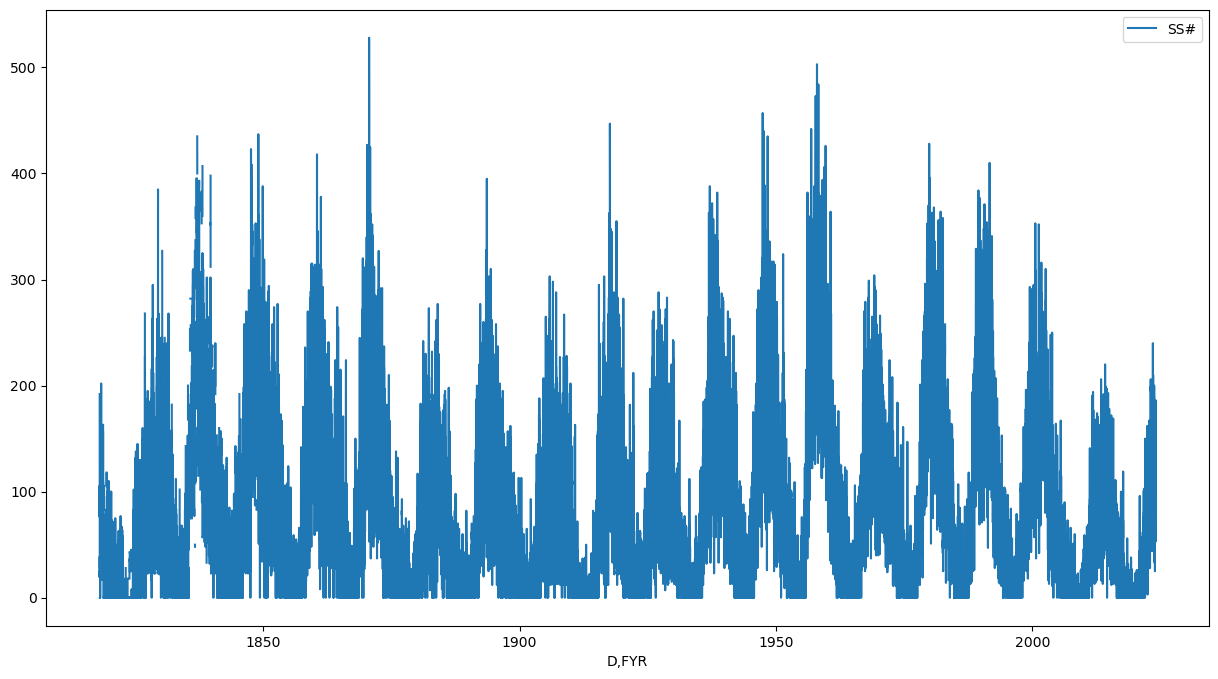

In [4]:
#plot sndata SS# vs D,FYR for visual inspection
sndata.plot(x='D,FYR', y='SS#', kind='line')
legend = ['Sunspot Number']
plt.gcf().set_size_inches(15, 8)

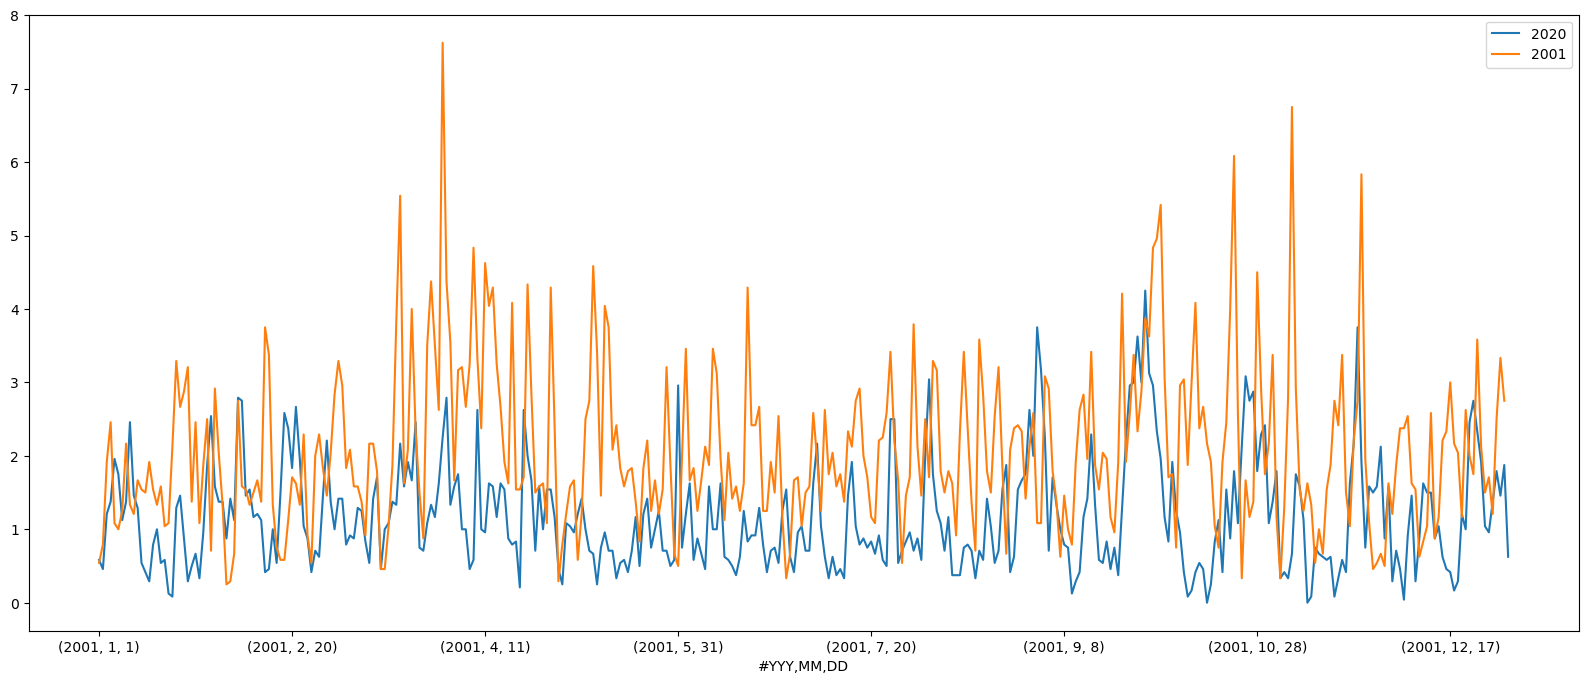

In [5]:
#This block shows that on average in more active years (solar max vs solar min yrs) the Kp index is higher
plt.figure(figsize=(20, 8))

#2020 is a solar min year
year1 = 2020
daily_avgs = kpdata[kpdata['#YYY'] == year1].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year1)

#2001 is a solar max year
year2 = 2001
daily_avgs = kpdata[kpdata['#YYY'] == year2].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year2)

plt.legend()

In [31]:
#this block creates the time series for the sunspot data
ts = pd.Series(data=sndata['SS#'].values, index=sndata['time'])

#interpolate data to fill in NaN(-1) values **FIX//REPOSITION**
ts = ts.interpolate(method='linear')

Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk (The 2-D image of the sun that the viewer is looking at).

time
1818-01-01           NaN
1818-01-02           NaN
1818-01-03           NaN
1818-01-04           NaN
1818-01-05           NaN
1818-01-06           NaN
1818-01-07           NaN
1818-01-08     65.000000
1818-01-09     59.400000
1818-01-10     53.800000
1818-01-11     48.200000
1818-01-12     42.600000
1818-01-13     37.000000
1818-01-14     47.000000
1818-01-15     57.000000
1818-01-16     67.000000
1818-01-17     77.000000
1818-01-18     98.000000
1818-01-19    105.000000
1818-01-20     91.666667
dtype: float64


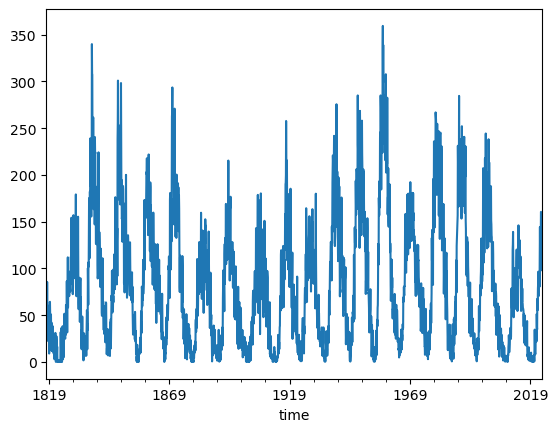

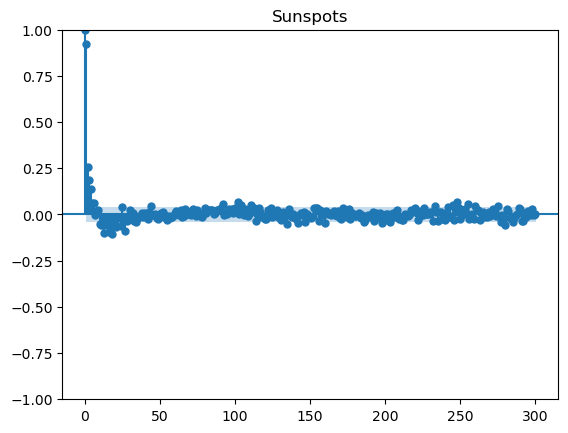

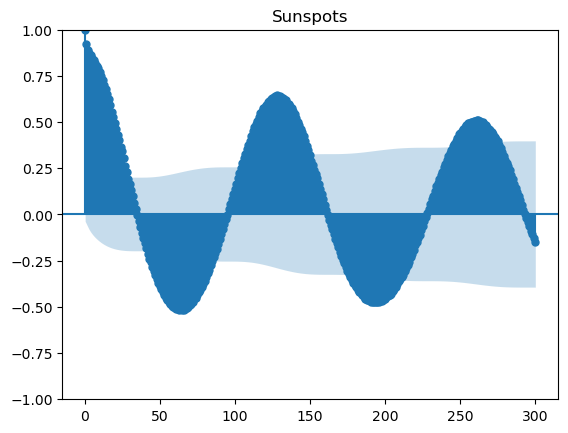

In [47]:
#this block splits makes the monthly ts for sarima experimentation

#print first 20 rows of ts
print(ts.head(20))

ts_month = ts.resample('MS').mean()
ts_month.plot()
plt.show()

#this block plots information needed for trend parameters: order = (p,d,q)
plot_pacf(ts_month,lags=300,title='Sunspots')
plt.show()

plot_acf(ts_month,lags=300,title='Sunspots')
plt.show()

#SARIMAX TAKES 10+ MINUTES TO RUN, MONTHLY 

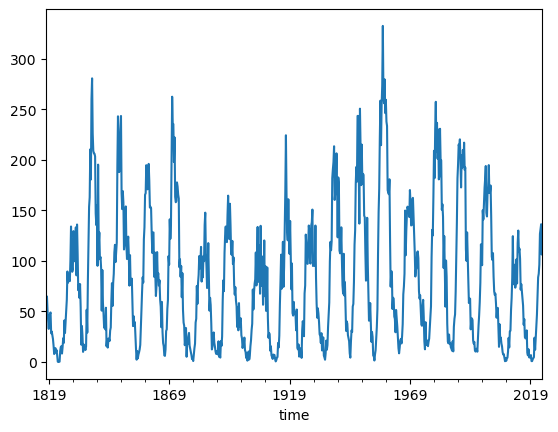

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


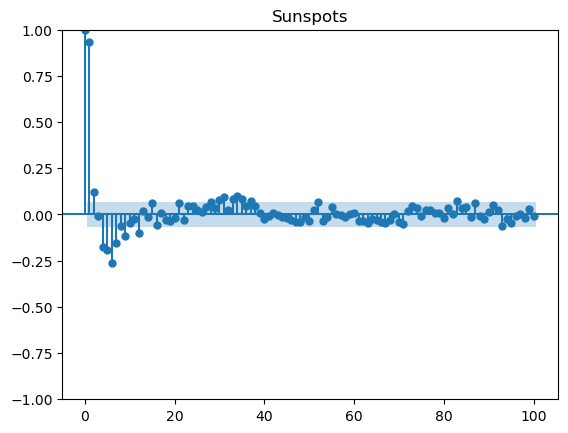

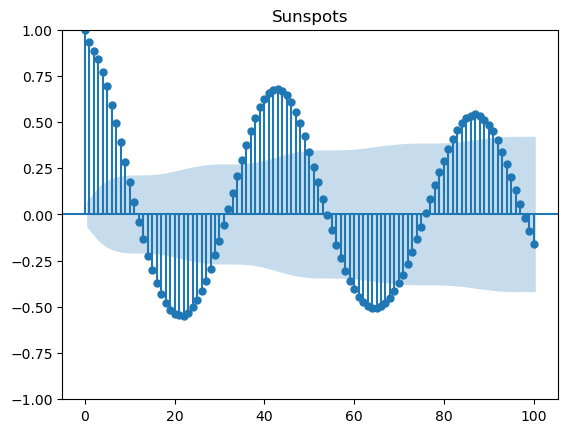

In [48]:
ts_qtr = ts.resample('Q').mean()
ts_qtr.plot()
plt.show()

#this block plots information needed for trend parameters: order = (p,d,q)
plot_pacf(ts_qtr,lags=100,title='Sunspots')
plt.show()

plot_acf(ts_qtr,lags=100,title='Sunspots')
plt.show()

In [70]:
model = sm.tsa.statespace.SARIMAX(ts_qtr, trend='n', order=(3,0,10), seasonal_order=(1,1,0,43))
results = model.fit()
print(results.summary())

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  825
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 43)   Log Likelihood               -3658.056
Date:                              Fri, 22 Mar 2024   AIC                           7346.111
Time:                                      08:45:21   BIC                           7416.039
Sample:                                  03-31-1818   HQIC                          7373.003
                                       - 03-31-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8948      0.123      7.269      0.000       0.654       1.136
ar.L2          0.77

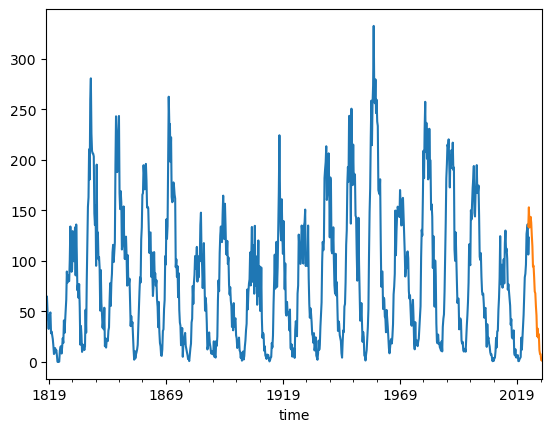

In [125]:
forecast = results.predict(start = ts_qtr.index[-2], end= ts_qtr.index[-2] + pd.DateOffset(months=70), dynamic= True) 
ts_qtr.plot()
forecast.plot()
plt.show()


In [126]:
forecast.head(30)

2023-12-31    134.406861
2024-03-31    153.071265
2024-06-30    133.033378
2024-09-30    136.820781
2024-12-31    143.647621
2025-03-31    137.970619
2025-06-30    125.255202
2025-09-30    114.625071
2025-12-31     94.428953
2026-03-31     95.338667
2026-06-30     83.673627
2026-09-30     69.779943
2026-12-31     67.931310
2027-03-31     55.375508
2027-06-30     46.062138
2027-09-30     25.401284
2027-12-31     33.016366
2028-03-31     24.060979
2028-06-30     27.474571
2028-09-30     11.632745
2028-12-31      7.930142
2029-03-31      7.680855
2029-06-30      1.791782
2029-09-30      1.572941
2029-12-31      0.971998
Freq: Q-DEC, Name: predicted_mean, dtype: float64